1. 以下关于集成学习的说法不正确的是：   
   A. 在集成学习中，我们可以为数据空间的不同区域使用不同的预测模型，再将预测结果进行组合。   
   B. 一组预测模型可以有多种方式进行集成学习。   
   C. 有效的集成学习需要集合中的模型具有单一性，最好将同一类型的预测模型结合起来。   
   D. 训练集成模型时，单个模型的参数不会随之更新。  



答：  
A. 正确。数据空间的不同部分可能有比较大差别的模式，在不同区域学习不同的预测模型再组合起来就可以预测这个数据空间的数据了。  
B. 正确。一组预测模型可以用不同的方法集成达到不同的效果，比如Bagging，Boosting，Stacking等。  
C. 错误。集成学习就是集合不同结构类型的模型才能获得更好的性能的。  
D. 正确。单个模型的参数是训练单个模型的时候确定好。集成学习模型训练是将训练好的模型结合起来。


---

   2. 以下关于提升算法的说法正确的是：   
A. AdaBoost算法中，$err$绝对值越小的模型权重绝对值越大，在集成模型中占有主导地位。   
B. AdaBoost算法中，需要按照之前学习器的结果对训练数据进行加权采样。   
C. GBDT算法用到了“梯度反方向是函数值下降最快方向”的思想。   
D. GBDT的正则化约束只考虑了叶节点的数目  

答：  
A. 正确。AdaBoost是通过错误率来确定每个学习器的权重的，错误率越小权重就越大，就在模型中起到比较重要的影响。  
B. 正确。AdaBoost会给训练数据加权进行调整，使得前一轮的错误样本在下一轮更加被关注。  
C. 正确。这是GBDT的核心思想。将梯度和决策树结合，每次迭代拟合决策树模型进行更新。  
D. 错误。GBDT的正则化约束还考虑了树的深度，叶结点的输出值等，综合约束来降低过拟合。


---

3. 由基础学习器提取特征后再供给元学习器进一步学习，这一特征提取的思想在前面哪些章节也出现过？为什么合适的特征提取往往能提升算法的表现？

答：特征提取可以从大量的特征洪提取合适的特征，减少特征的维度和噪声，找到更加能拟合数据模式的重要特征，达到更好的泛化效果。而且特征提取可以降低计算的复杂度，消除一些不必要的关系影响。  
特征提取在许多地方都出现过，比如CNN中的对图像数据的提取（池化），RNN中对序列中潜在关系的提取（GRU），SVM中的特征映射，决策树中的对数据的分割提取等等。

---

4. 基于本章代码，尝试非线性的元分类器，如神经网络和决策树，观察原始数据拼接到新数据上的模型预测性能的改变。

非线性元分类器能捕捉更复杂的数据关系，尤其是对于非线性特征。原始数据拼接新数据后，模型的性能有所下降，可能是因为原始特征中带有噪音和不相关的信息干扰了元学习。不过影响并不大，说明基分类器已经基本上学习到了特征信息。

In [31]:
# 导入需要的库
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split

In [32]:
# 创建随机数据集
X, y = make_classification(
    n_samples = 1000, # 样本数量
    n_features = 16, # 每个样本的特征数量
    n_informative = 5, # 与输出y有关联的特征量
    n_redundant = 2, # 对输出y没贡献的特征量
    n_classes = 2, # 两个类别
    flip_y = 0.1, # 标签的错误率
    random_state = 2024
)

print(X.shape)
print(y.shape)

(1000, 16)
(1000,)


In [33]:
from sklearn.model_selection import KFold
from sklearn.base import clone

# 堆垛分类器，继承sklearn中的集成分类器基类EnsembleClassifier
class StackingClassifier():

    def __init__(
        self, 
        classifiers, # 基础分类器
        meta_classifier, # 元分类器
        concat_feature=False, # 是否将原始数据拼接在新数据上
        kfold=5 # K折交叉验证
    ):
        self.classifiers = classifiers
        self.meta_classifier = meta_classifier
        self.concat_feature = concat_feature
        self.kf = KFold(n_splits=kfold)
        # 为了在测试时计算平均，我们需要保留每个分类器
        self.k_fold_classifiers = []
        
    def fit(self, X, y):
        # 用X和y训练基础分类器和元分类器
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]
        
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((n_samples, 0))
        for classifier in self.classifiers:
            self.k_fold_classifiers.append([])
            # 训练每个基础分类器
            predict_proba = np.zeros((n_samples, self.n_classes))
            for train_idx, test_idx in self.kf.split(X):
                # 交叉验证
                clf = clone(classifier)
                clf.fit(X[train_idx], y[train_idx])
                predict_proba[test_idx] = clf.predict_proba(X[test_idx])
                self.k_fold_classifiers[-1].append(clf)
            features = np.concatenate([features, predict_proba], axis=-1)
        # 训练元分类器
        self.meta_classifier.fit(features, y)
    
    def _get_features(self, X):
        # 计算输入X的特征
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((X.shape[0], 0))
        for k_classifiers in self.k_fold_classifiers:
            k_feat = np.mean([clf.predict_proba(X)
                for clf in k_classifiers], axis=0)
            features = np.concatenate([features, k_feat], axis=-1)
        return features
    
    def predict(self, X):
        return self.meta_classifier.predict(self._get_features(X))
        
    def score(self, X, y):
        return self.meta_classifier.score(self._get_features(X), y)

In [34]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.neural_network import MLPClassifier
from sklearn import tree

# 划分训练集和测试集
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

# 基础分类器
rf = RFC(n_estimators=10, max_features='sqrt', 
    random_state=0).fit(X_train, y_train)
knc = KNC().fit(X_train, y_train)
# multi_class='ovr'表示二分类问题
lr = LR(solver='liblinear', multi_class='ovr', 
    random_state=0).fit(X_train, y_train)
print('随机森林：', rf.score(X_test, y_test))
print('KNN：', knc.score(X_test, y_test))
print('逻辑斯谛回归：', lr.score(X_test, y_test))


# 元分类器
meta_lr = LR(solver='liblinear', multi_class='ovr', random_state=0) # 线性元分类器
meta_DTC = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3) # 决策树元分类器
meta_nn = MLPClassifier(hidden_layer_sizes=(16,), random_state=1)

# -------------------- #
# 元分类器为线性回归
sc_lr = StackingClassifier([rf, knc, lr], meta_lr, concat_feature=False)
sc_lr.fit(X_train, y_train)
print('Stacking分类器（线性）：', sc_lr.score(X_test, y_test))

# 带原始特征的stacking分类器
sc_lr_concat = StackingClassifier([rf, knc, lr], meta_lr, concat_feature=True)
sc_lr_concat.fit(X_train, y_train)
print('带原始特征的Stacking分类器（线性）：', sc_lr_concat.score(X_test, y_test))

# -------------------- #
# 元分类器为决策树
sc_dtc = StackingClassifier([rf, knc, lr], meta_DTC, concat_feature=False)
sc_dtc.fit(X_train, y_train)
print('Stacking分类器（决策树）：', sc_dtc.score(X_test, y_test))

# 带原始特征的stacking分类器
sc_dtc_concat = StackingClassifier([rf, knc, lr], meta_DTC, concat_feature=True)
sc_dtc_concat.fit(X_train, y_train)
print('带原始特征的Stacking分类器（决策树）：', sc_dtc_concat.score(X_test, y_test))

# -------------------- #
# 元分类器为MLP
sc_nn = StackingClassifier([rf, knc, lr], meta_nn, concat_feature=False)
sc_nn.fit(X_train, y_train)
print('Stacking分类器（神经网络）：', sc_nn.score(X_test, y_test))


# 带原始特征的stacking分类器
sc_nn_concat = StackingClassifier([rf, knc, lr], meta_nn, concat_feature=True)
sc_nn_concat.fit(X_train, y_train)
print('带原始特征的Stacking分类器（神经网络）：', sc_nn_concat.score(X_test, y_test))


随机森林： 0.795
KNN： 0.83
逻辑斯谛回归： 0.74
Stacking分类器（线性）：

 0.84
带原始特征的Stacking分类器（线性）： 0.825
Stacking分类器（决策树）： 0.825
带原始特征的Stacking分类器（决策树）： 0.815
Stacking分类器（神经网络）： 0.84
带原始特征的Stacking分类器（神经网络）： 0.83


d:\miniconda\envs\d2l\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


---

5. 在提升算法中，弱学习器的数量越多，元学习器的效果是否一定越好？调整AdaBoost和GBDT代码中弱学习器的数量，验证你的想法。

答：不是。  
弱学习器过多会导致模型过拟合，效果反而更差，随着弱学习器到一定数量后，增加弱学习器不会带来更好的效果，反而会因为过拟合导致效果更差，而且数量较大的过拟合也消耗了比较大的计算资源。

  0%|          | 0/40 [00:00<?, ?it/s]d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
  8%|▊         | 3/40 [00:00<00:02, 17.68it/s]d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

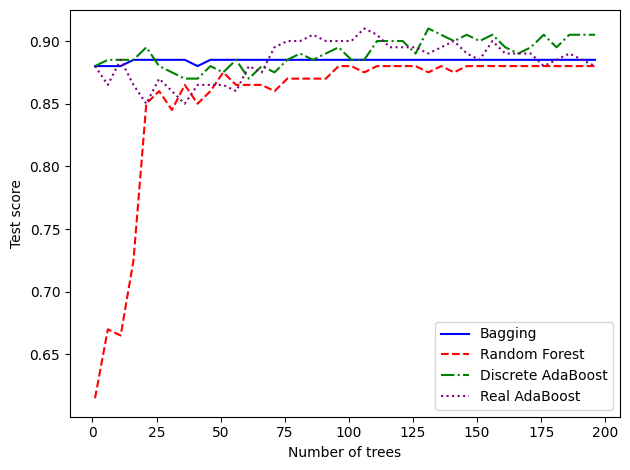

In [35]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split

# 创建随机数据集
X, y = make_classification(
    n_samples=1000, # 数据集大小
    n_features=16, # 特征数，即数据维度
    n_informative=5, # 有效特征个数
    n_redundant=2, # 冗余特征个数，为有效特征的随机线性组合
    n_classes=2, # 类别数
    flip_y=0.1, # 类别随机的样本个数，该值越大，分类越困难
    random_state=0 # 随机种子
)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)



from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier

# 初始化stump
stump = DTC(max_depth=1, min_samples_leaf=1, random_state=0)

# 弱分类器个数
M = np.arange(1, 201, 5)  # 可以调整数量

# 存储不同集成方法在测试集的得分
bg_score = []
rf_score = []
dsc_ada_score = []
real_ada_score = []
plt.figure()

with tqdm(M) as pbar:
    for m in pbar:
        # bagging算法
        bc = BaggingClassifier(estimator=stump, 
            n_estimators=m, random_state=0)  # 注意这里的和网页教程代码不同
        bc.fit(X_train, y_train)
        bg_score.append(bc.score(X_test, y_test))
        # 随机森林算法
        rfc = RandomForestClassifier(n_estimators=m, max_depth=1, 
            min_samples_leaf=1, random_state=0)
        rfc.fit(X_train, y_train)
        rf_score.append(rfc.score(X_test, y_test))
        # 离散 AdaBoost，SAMME是分步加性模型（stepwise additive model）的缩写
        dsc_adaboost = AdaBoostClassifier(estimator=stump, 
            n_estimators=m, algorithm='SAMME', random_state=0)
        dsc_adaboost.fit(X_train, y_train)
        dsc_ada_score.append(dsc_adaboost.score(X_test, y_test))
        # 实 AdaBoost，SAMME.R表示弱分类器输出实数
        real_adaboost = AdaBoostClassifier(estimator=stump, 
            n_estimators=m, algorithm='SAMME.R', random_state=0)
        real_adaboost.fit(X_train, y_train)
        real_ada_score.append(real_adaboost.score(X_test, y_test))

# 绘图
plt.plot(M, bg_score, color='blue', label='Bagging')
plt.plot(M, rf_score, color='red', ls='--', label='Random Forest')
plt.plot(M, dsc_ada_score, color='green', ls='-.', label='Discrete AdaBoost')
plt.plot(M, real_ada_score, color='purple', ls=':', label='Real AdaBoost')
plt.xlabel('Number of trees')
plt.ylabel('Test score')
plt.legend()
plt.tight_layout()
plt.show()

d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\li

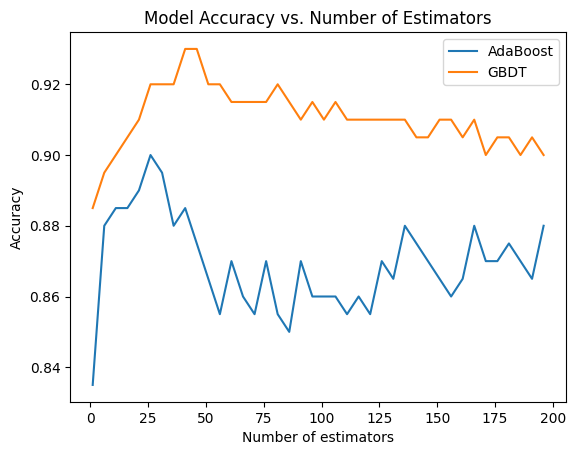

In [36]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 创建随机数据集
X, y = make_classification(
    n_samples=1000, 
    n_features=16,
    n_informative=5, 
    n_redundant=2,
    n_classes=2,
    flip_y=0.1,
    random_state=0
    )

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义弱学习器的数量范围
n_estimators = np.arange(1, 201, 5)

# 初始化AdaBoost和GBDT
adaboost = AdaBoostClassifier(estimator=None, n_estimators=n_estimators[0], random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=n_estimators[0])

# 存储每种算法的得分
adaboost_scores = []
gbdt_scores = []

# 遍历不同的n_estimators值
for n in n_estimators:
    # 训练AdaBoost模型
    adaboost.n_estimators = n
    adaboost.fit(X_train, y_train)
    adaboost_score = accuracy_score(y_test, adaboost.predict(X_test))
    adaboost_scores.append(adaboost_score)
    
    # 训练GBDT模型
    gbdt.n_estimators = n
    gbdt.fit(X_train, y_train)
    gbdt_score = accuracy_score(y_test, gbdt.predict(X_test))
    gbdt_scores.append(gbdt_score)

# 绘图
plt.plot(n_estimators, adaboost_scores, label='AdaBoost')
plt.plot(n_estimators, gbdt_scores, label='GBDT')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of Estimators')
plt.legend()
plt.show()

d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
d:\miniconda\envs\d2l\li

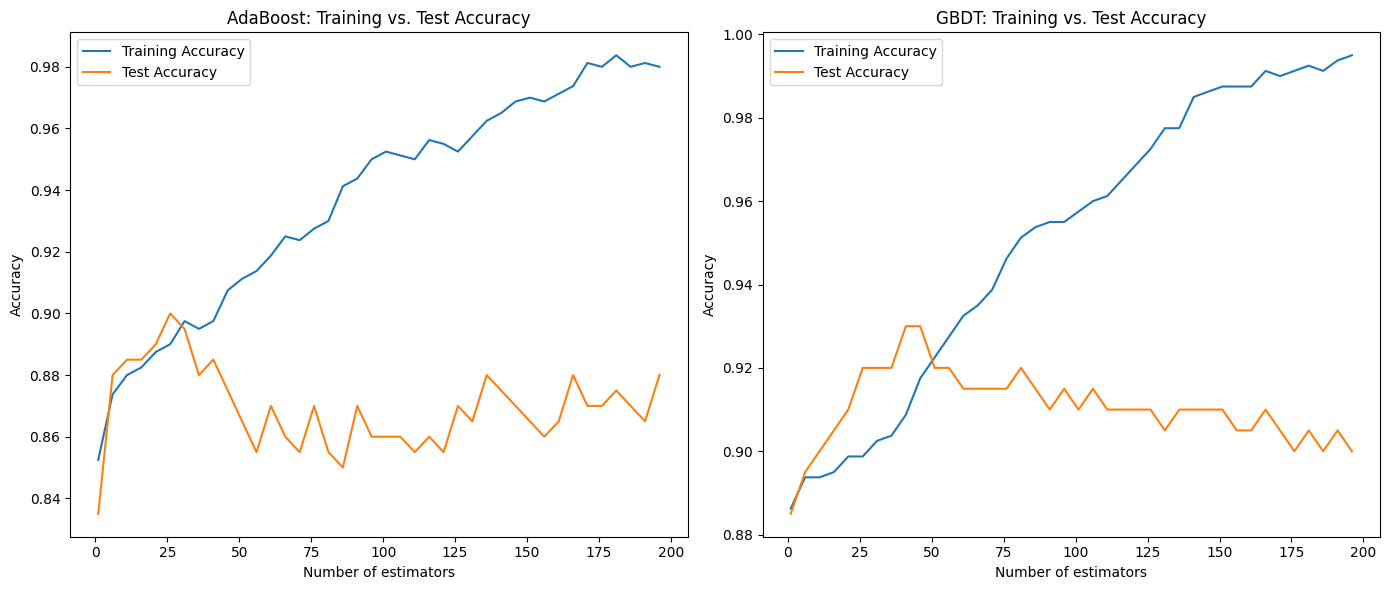

In [37]:
# 存储每种算法的得分，包括训练集和测试集得分
adaboost_train_scores = []
adaboost_test_scores = []
gbdt_train_scores = []
gbdt_test_scores = []

# 遍历不同的n_estimators值
for n in n_estimators:
    # 训练AdaBoost模型
    adaboost.n_estimators = n
    adaboost.fit(X_train, y_train)
    adaboost_train_score = accuracy_score(y_train, adaboost.predict(X_train))  # 训练集准确度
    adaboost_test_score = accuracy_score(y_test, adaboost.predict(X_test))   # 测试集准确度
    adaboost_train_scores.append(adaboost_train_score)
    adaboost_test_scores.append(adaboost_test_score)
    
    # 训练GBDT模型
    gbdt.n_estimators = n
    gbdt.fit(X_train, y_train)
    gbdt_train_score = accuracy_score(y_train, gbdt.predict(X_train))       # 训练集准确度
    gbdt_test_score = accuracy_score(y_test, gbdt.predict(X_test))         # 测试集准确度
    gbdt_train_scores.append(gbdt_train_score)
    gbdt_test_scores.append(gbdt_test_score)

# 绘图 - AdaBoost训练集与测试集准确度
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(n_estimators, adaboost_train_scores, label='Training Accuracy')
plt.plot(n_estimators, adaboost_test_scores, label='Test Accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost: Training vs. Test Accuracy')
plt.legend()

# 绘图 - GBDT训练集与测试集准确度
plt.subplot(1, 2, 2)
plt.plot(n_estimators, gbdt_train_scores, label='Training Accuracy')
plt.plot(n_estimators, gbdt_test_scores, label='Test Accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('GBDT: Training vs. Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

---

6. 基于xgboost库，对于本章涉及的回归任务，调试树的数量上限、每棵树的深度上限、学习率，观察其训练模型性能的改变，讨论是大量较浅的树组成的GBDT模型更强，还是少量的较深的树组成的GBDT模型更强。

答：过多增加树的数量，加深树的深度和较大的学习率会导致过拟合。  
      大量较浅的树组成的GBDT模型效果更好一些。

In [38]:
import xgboost as xgb
from sklearn.datasets import make_friedman1

In [39]:
# 生成回归数据集
reg_X, reg_y = make_friedman1(
    n_samples=2000, # 样本数目
    n_features=100, # 特征数目
    noise=0.5, # 噪声的标准差
    random_state=0 # 随机种子
)

# 划分训练集与测试集
reg_X_train, reg_X_test, reg_y_train, reg_y_test = \
    train_test_split(reg_X, reg_y, test_size=0.2, random_state=0)

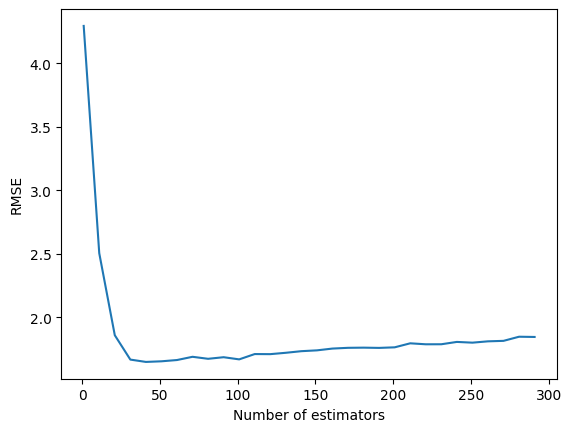

In [40]:
# 树的数量
def rmse(regressor):
    # 计算regressor在测试集上的RMSE
    y_pred = regressor.predict(reg_X_test)
    return np.sqrt(np.mean((y_pred - reg_y_test) ** 2))



M = np.arange(1, 301, 10)
diff_rmse = []

for m in M:
    # XGBoost回归树
    xgbr = xgb.XGBRegressor(
        n_estimators=m, # 弱分类器数目
        max_depth=1, # 决策树最大深度
        learning_rate=0.5, # 学习率
        gamma=0.0, # 对决策树叶节点数目的惩罚系数，当弱分类器为stump时不起作用
        reg_lambda=0.1, # L2正则化系数
        subsample=0.5, # 与随机森林类似，表示采样特征的比例
        objective='reg:squarederror', # MSE损失函数
        eval_metric='rmse', # 用RMSE作为评价指标
        random_state=0 # 随机种子
    )

    xgbr.fit(reg_X_train, reg_y_train)
    # print(f"XGBoost rmse：{rmse(xgbr):.3f}")
    diff_rmse.append(rmse(xgbr))

plt.plot(M, diff_rmse, label="XGBoost rmse")
plt.xlabel("Number of estimators")
plt.ylabel("RMSE")
plt.show()

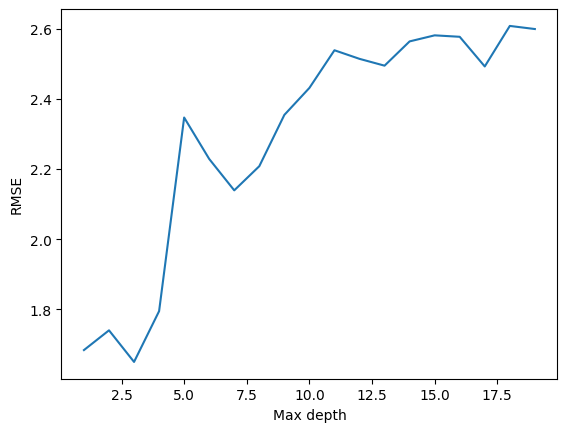

In [43]:
# 树的深度
def rmse(regressor):
    # 计算regressor在测试集上的RMSE
    y_pred = regressor.predict(reg_X_test)
    return np.sqrt(np.mean((y_pred - reg_y_test) ** 2))



M = np.arange(1, 20)
diff_rmse = []

for m in M:
    # XGBoost回归树
    xgbr = xgb.XGBRegressor(
        n_estimators=100, # 弱分类器数目
        max_depth=m, # 决策树最大深度
        learning_rate=0.5, # 学习率
        gamma=0.0, # 对决策树叶节点数目的惩罚系数，当弱分类器为stump时不起作用
        reg_lambda=0.1, # L2正则化系数
        subsample=0.5, # 与随机森林类似，表示采样特征的比例
        objective='reg:squarederror', # MSE损失函数
        eval_metric='rmse', # 用RMSE作为评价指标
        random_state=0 # 随机种子
    )

    xgbr.fit(reg_X_train, reg_y_train)
    # print(f"XGBoost rmse：{rmse(xgbr):.3f}")
    diff_rmse.append(rmse(xgbr))

plt.plot(M, diff_rmse, label="XGBoost rmse")
plt.xlabel("Max depth")
plt.ylabel("RMSE")
plt.show()

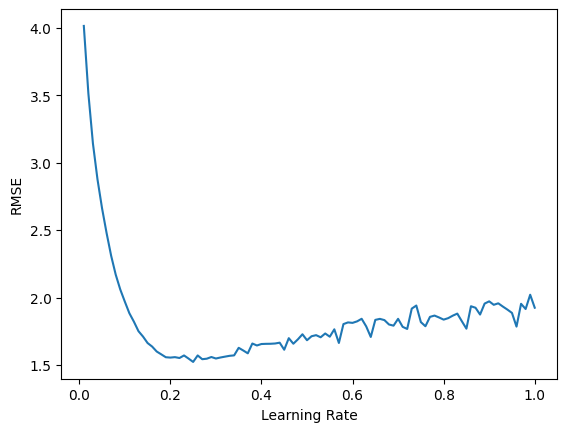

In [42]:
# 不同学习率
def rmse(regressor):
    # 计算regressor在测试集上的RMSE
    y_pred = regressor.predict(reg_X_test)
    return np.sqrt(np.mean((y_pred - reg_y_test) ** 2))



M = np.arange(0.01, 1.01, 0.01)
diff_rmse = []

for m in M:
    # XGBoost回归树
    xgbr = xgb.XGBRegressor(
        n_estimators=100, # 弱分类器数目
        max_depth=1, # 决策树最大深度
        learning_rate=m, # 学习率
        gamma=0.0, # 对决策树叶节点数目的惩罚系数，当弱分类器为stump时不起作用
        reg_lambda=0.1, # L2正则化系数
        subsample=0.5, # 与随机森林类似，表示采样特征的比例
        objective='reg:squarederror', # MSE损失函数
        eval_metric='rmse', # 用RMSE作为评价指标
        random_state=0 # 随机种子
    )

    xgbr.fit(reg_X_train, reg_y_train)
    # print(f"XGBoost rmse：{rmse(xgbr):.3f}")
    diff_rmse.append(rmse(xgbr))

plt.plot(M, diff_rmse, label="XGBoost rmse")
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.show()

In [51]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 创建一个回归数据集
X, y = make_regression(n_samples=1000, n_features=20, noise=0.5)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义参数范围
n_estimators_range = [50, 100, 200, 300, 400, 500]
max_depth_range = [1, 3, 5, 7, 9]
learning_rates = [0.01, 0.1, 0.5, 1]

# 存储性能结果
rmse_results = []

# 遍历所有参数组合
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for learning_rate in learning_rates:
            # 初始化XGBoost回归树
            xgbr = xgb.XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                n_jobs=4,  # 使用多线程加速
                random_state=0
            )
            
            # 训练模型
            xgbr.fit(X_train, y_train)
            
            # 计算RMSE
            y_pred = xgbr.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse_results.append((n_estimators, max_depth, learning_rate, rmse))

# 输出性能结果
for result in rmse_results:
    print(f"Trees: {result[0]}, Depth: {result[1]}, LR: {result[2]}, RMSE: {result[3]:.4f}")

Trees: 50, Depth: 1, LR: 0.01, RMSE: 154.1189
Trees: 50, Depth: 1, LR: 0.1, RMSE: 106.1716
Trees: 50, Depth: 1, LR: 0.5, RMSE: 51.3763
Trees: 50, Depth: 1, LR: 1, RMSE: 58.7287
Trees: 50, Depth: 3, LR: 0.01, RMSE: 138.6700
Trees: 50, Depth: 3, LR: 0.1, RMSE: 68.7939
Trees: 50, Depth: 3, LR: 0.5, RMSE: 58.1412
Trees: 50, Depth: 3, LR: 1, RMSE: 77.5115
Trees: 50, Depth: 5, LR: 0.01, RMSE: 128.9892
Trees: 50, Depth: 5, LR: 0.1, RMSE: 60.1172
Trees: 50, Depth: 5, LR: 0.5, RMSE: 65.2727
Trees: 50, Depth: 5, LR: 1, RMSE: 94.5322
Trees: 50, Depth: 7, LR: 0.01, RMSE: 125.5656
Trees: 50, Depth: 7, LR: 0.1, RMSE: 72.3043
Trees: 50, Depth: 7, LR: 0.5, RMSE: 80.6987
Trees: 50, Depth: 7, LR: 1, RMSE: 106.4392
Trees: 50, Depth: 9, LR: 0.01, RMSE: 125.9720
Trees: 50, Depth: 9, LR: 0.1, RMSE: 80.7951
Trees: 50, Depth: 9, LR: 0.5, RMSE: 86.7423
Trees: 50, Depth: 9, LR: 1, RMSE: 112.8106
Trees: 100, Depth: 1, LR: 0.01, RMSE: 146.1491
Trees: 100, Depth: 1, LR: 0.1, RMSE: 79.7447
Trees: 100, Depth: 1, LR:

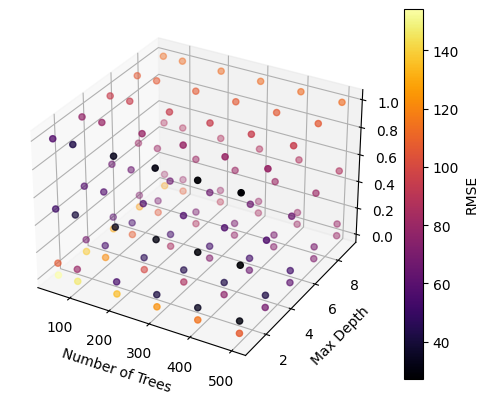

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 将rmse_results转换为适合绘图的格式
results = np.array(rmse_results)
n_estimators = results[:, 0]
max_depth = results[:, 1]
learning_rate = results[:, 2]
rmse = results[:, 3]

# 创建一个3D散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
scatter = ax.scatter(n_estimators, max_depth, learning_rate, c=rmse, cmap='inferno')

# 添加颜色条
plt.colorbar(scatter, label='RMSE')

# 设置轴标签
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Learning Rate')

# 显示图表
plt.show()


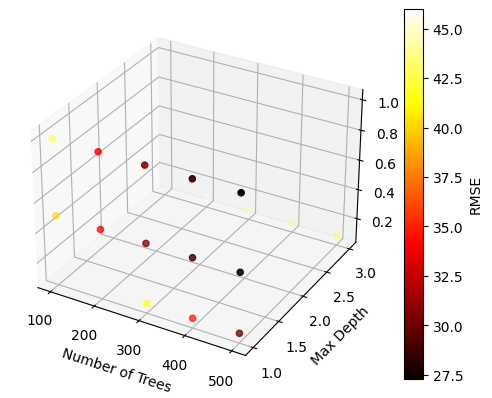

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 将rmse_results转换为适合绘图的格式
results = np.array(rmse_results)
n_estimators = results[:, 0]
max_depth = results[:, 1]
learning_rate = results[:, 2]
rmse = results[:, 3]

# 设置阈值，只显示RMSE小于该阈值的数据点
threshold_rmse = 50
filtered_indices = np.where(rmse < threshold_rmse)

# 创建一个3D散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
scatter = ax.scatter(n_estimators[filtered_indices], max_depth[filtered_indices], learning_rate[filtered_indices], c=rmse[filtered_indices], cmap='hot')

# 添加颜色条
plt.colorbar(scatter, label='RMSE')

# 设置轴标签
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Learning Rate')

# 显示图表
plt.show()


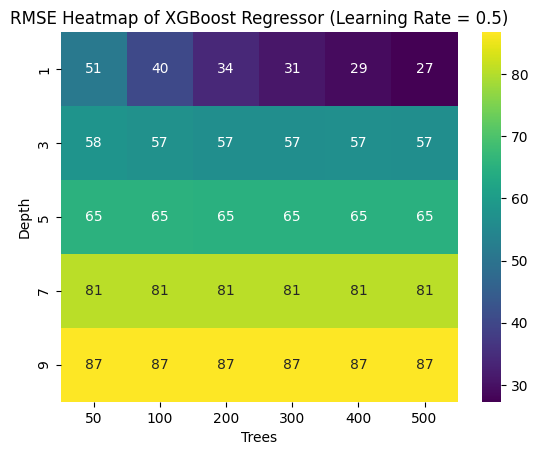

In [67]:
import seaborn as sns
import pandas as pd

# 筛选学习率为0.5的数据
df_filtered = df[df['Learning Rate'] == 0.5]

# 创建热图
pivot_table_filtered = df_filtered.pivot_table(values='RMSE', index='Depth', columns='Trees')
sns.heatmap(pivot_table_filtered, annot=True, cmap='viridis')
plt.title('RMSE Heatmap of XGBoost Regressor (Learning Rate = 0.5)')
plt.xlabel('Trees')
plt.ylabel('Depth')
plt.show()


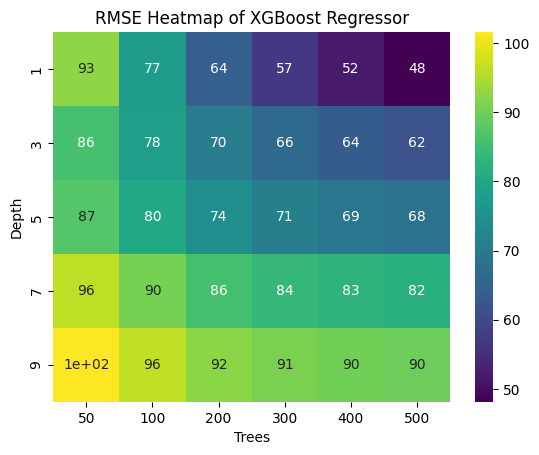

In [68]:
import seaborn as sns
import pandas as pd

# 创建数据框
df = pd.DataFrame(rmse_results, columns=['Trees', 'Depth', 'Learning Rate', 'RMSE'])

# 创建热图
pivot_table = df.pivot_table(values='RMSE', index='Depth', columns='Trees')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('RMSE Heatmap of XGBoost Regressor')
plt.xlabel('Trees')
plt.ylabel('Depth')
plt.show()

